<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Gabriel Gomes Ziegler
# Student 2: Fabio D'Agostino
# Student 3: Levente Zolyómi

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [125]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [127]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [128]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


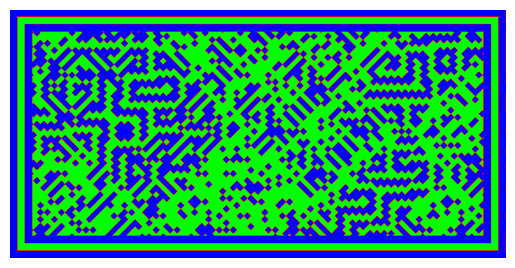

In [129]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [131]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def train_model(train_dataset, val_dataset, model, num_epochs, learning_rate=0.001, batch_size=64, device='cuda'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    writer = SummaryWriter()

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0
        train_correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

            output = model(X_batch)
            loss = criterion(output, y_batch_indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            train_correct += predicted.eq(y_batch_indices).sum().item()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_dataset)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

                output = model(X_batch)
                loss = criterion(output, y_batch_indices)

                _, predicted = output.max(1)
                val_correct += predicted.eq(y_batch_indices).sum().item()
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_dataset)

        # plot train and validation in the same plot
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch, )
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}')


In [132]:
from symconv import Slice, SymmetryConv2d, SymmetryPool

class SymmetryCNN(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN, self).__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc1 = nn.Linear(480, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # 8x5 activations  

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [133]:
batch_size = 128
epochs = 15

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

symmetryCNN = SymmetryCNN()

# train the model
train_model(train_dataset, val_dataset, symmetryCNN, num_epochs=epochs,
            learning_rate=0.001, batch_size=batch_size, device=device)

Epoch: 1/15, Train Loss: 3.523444, Train Acc: 0.334800, Val Loss: 1.245083, Val Acc: 0.347500
Epoch: 2/15, Train Loss: 1.144220, Train Acc: 0.383067, Val Loss: 1.102449, Val Acc: 0.372500
Epoch: 3/15, Train Loss: 1.061932, Train Acc: 0.434400, Val Loss: 1.338138, Val Acc: 0.349000
Epoch: 4/15, Train Loss: 0.979527, Train Acc: 0.524933, Val Loss: 0.855180, Val Acc: 0.643000
Epoch: 5/15, Train Loss: 0.741425, Train Acc: 0.707467, Val Loss: 0.725968, Val Acc: 0.669000
Epoch: 6/15, Train Loss: 0.504076, Train Acc: 0.848133, Val Loss: 0.391877, Val Acc: 0.915500
Epoch: 7/15, Train Loss: 0.301730, Train Acc: 0.932933, Val Loss: 0.274825, Val Acc: 0.941000
Epoch: 8/15, Train Loss: 0.173539, Train Acc: 0.971867, Val Loss: 0.177287, Val Acc: 0.949500
Epoch: 9/15, Train Loss: 0.109490, Train Acc: 0.984267, Val Loss: 0.136794, Val Acc: 0.957000
Epoch: 10/15, Train Loss: 0.073899, Train Acc: 0.990267, Val Loss: 0.085239, Val Acc: 0.985500
Epoch: 11/15, Train Loss: 0.053747, Train Acc: 0.993600, Va

In [134]:
# evaluate test accuracy
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
symmetryCNN.eval()
with torch.no_grad():
    test_correct = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_indices = torch.argmax(y_batch, axis=1)  # Convert one-hot to indices

        output = symmetryCNN(X_batch)
        _, predicted = output.max(1)
        test_correct += predicted.eq(y_batch_indices).sum().item()

    test_acc = test_correct / len(test_dataset)
    print(f'Test Acc: {test_acc:.6f}')

Test Acc: 0.998000


## Task 1: Question 5d

In [136]:
#EXPERIMENT 1
#[Tried] Changed the rotation number of the Slice layer before the second SymmetricConv2d layer from 1 to 4. The validation accuracy improves slower
#Added an additional slice-conv-pool step before the final fully connected layer. The validation accuracy improves slower but the accuracy reaches good level after a few more epochs
#by using a way less amount of parameters

from symconv import Slice, SymmetryConv2d, SymmetryPool

class SymmetryCNN_1(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN_1, self).__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        # global pattern (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv3 = SymmetryConv2d(in_filters=12, out_filters=1, kernel_size=1, stride=1, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc1 = nn.Linear(40, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # 8x5 activations  

        # Global pattern (NO ROTATION)
        x = self.slice1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)  

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# train the model
train_model(train_dataset, val_dataset, SymmetryCNN_1(), num_epochs=10, learning_rate=0.001, batch_size=64, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Epoch: 1/10, Train Loss: 2.448833, Train Acc: 0.602133, Val Loss: 0.368520, Val Acc: 0.873000
Epoch: 2/10, Train Loss: 0.165378, Train Acc: 0.958400, Val Loss: 0.078732, Val Acc: 0.985000
Epoch: 3/10, Train Loss: 0.047580, Train Acc: 0.991733, Val Loss: 0.036806, Val Acc: 0.991500
Epoch: 4/10, Train Loss: 0.025090, Train Acc: 0.996400, Val Loss: 0.019905, Val Acc: 0.996000
Epoch: 5/10, Train Loss: 0.015401, Train Acc: 0.998800, Val Loss: 0.017287, Val Acc: 0.994500
Epoch: 6/10, Train Loss: 0.012001, Train Acc: 0.998933, Val Loss: 0.013401, Val Acc: 0.997000
Epoch: 7/10, Train Loss: 0.016451, Train Acc: 0.997333, Val Loss: 0.011385, Val Acc: 0.997500
Epoch: 8/10, Train Loss: 0.008275, Train Acc: 0.998667, Val Loss: 0.018257, Val Acc: 0.994500
Epoch: 9/10, Train Loss: 0.005424, Train Acc: 0.999733, Val Loss: 0.006707, Val Acc: 0.998500
Epoch: 10/10, Train Loss: 0.006370, Train Acc: 0.999067, Val Loss: 0.011032, Val Acc: 0.996000


In [137]:
#EXPERIMENT 2
#Changed activation function with ELU instead of ReLU. Validation accuracy improves slower. Probably it's trivial
from symconv import Slice, SymmetryConv2d, SymmetryPool

class SymmetryCNN_2(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN_2, self).__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.elu = nn.ELU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc1 = nn.Linear(480, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.elu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.pool(x) # 8x5 activations  

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)

        return x

# train the model
train_model(train_dataset, val_dataset, SymmetryCNN_2(), num_epochs=10, learning_rate=0.001, batch_size=64, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Epoch: 1/10, Train Loss: 3.991655, Train Acc: 0.343733, Val Loss: 1.579590, Val Acc: 0.347000
Epoch: 2/10, Train Loss: 1.203628, Train Acc: 0.384133, Val Loss: 1.466566, Val Acc: 0.385000
Epoch: 3/10, Train Loss: 1.025863, Train Acc: 0.500933, Val Loss: 1.065092, Val Acc: 0.462500
Epoch: 4/10, Train Loss: 0.703558, Train Acc: 0.708400, Val Loss: 0.562698, Val Acc: 0.773500
Epoch: 5/10, Train Loss: 0.315916, Train Acc: 0.906933, Val Loss: 0.183595, Val Acc: 0.955500
Epoch: 6/10, Train Loss: 0.136452, Train Acc: 0.970133, Val Loss: 0.115265, Val Acc: 0.973500
Epoch: 7/10, Train Loss: 0.076144, Train Acc: 0.987200, Val Loss: 0.080078, Val Acc: 0.987000
Epoch: 8/10, Train Loss: 0.044733, Train Acc: 0.994000, Val Loss: 0.090027, Val Acc: 0.966500
Epoch: 9/10, Train Loss: 0.032787, Train Acc: 0.995867, Val Loss: 0.046153, Val Acc: 0.988500
Epoch: 10/10, Train Loss: 0.034978, Train Acc: 0.992400, Val Loss: 0.059758, Val Acc: 0.981500


In [138]:
#EXPERIMENT 3
#Removed the linear layer before the output layer. The loss doesn't converge anymore, really interesting 
from symconv import Slice, SymmetryConv2d, SymmetryPool

class SymmetryCNN_3(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN_3, self).__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Classifier head
        self.fc2 = nn.Linear(480, n_classes)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # 8x5 activations  

        # Classifier head
        x = torch.flatten(x, 1)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# train the model
train_model(train_dataset, val_dataset, SymmetryCNN_3(), num_epochs=10, learning_rate=0.001, batch_size=64, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Epoch: 1/10, Train Loss: 3.828561, Train Acc: 0.334667, Val Loss: 1.989591, Val Acc: 0.345000
Epoch: 2/10, Train Loss: 1.520546, Train Acc: 0.353600, Val Loss: 1.238425, Val Acc: 0.360000
Epoch: 3/10, Train Loss: 1.250538, Train Acc: 0.351467, Val Loss: 1.219656, Val Acc: 0.336500
Epoch: 4/10, Train Loss: 1.178595, Train Acc: 0.365600, Val Loss: 1.178793, Val Acc: 0.339000
Epoch: 5/10, Train Loss: 1.145041, Train Acc: 0.376667, Val Loss: 1.126086, Val Acc: 0.372500
Epoch: 6/10, Train Loss: 1.137218, Train Acc: 0.369067, Val Loss: 1.170730, Val Acc: 0.361000
Epoch: 7/10, Train Loss: 1.120919, Train Acc: 0.387867, Val Loss: 1.130089, Val Acc: 0.372500
Epoch: 8/10, Train Loss: 1.109911, Train Acc: 0.402000, Val Loss: 1.124037, Val Acc: 0.370500
Epoch: 9/10, Train Loss: 1.104551, Train Acc: 0.400267, Val Loss: 1.129454, Val Acc: 0.370500
Epoch: 10/10, Train Loss: 1.100151, Train Acc: 0.412933, Val Loss: 1.116804, Val Acc: 0.387000


# Task 2: Carpet Matching 

In [11]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


# Modify model to produce embeddings and use triplet loss on training

In [12]:
from symconv import Slice, SymmetryConv2d, SymmetryPool

class EmbeddingCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        
        # unit cell (4-fold rotation), 18 filters (18 different unit cells)
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=18, kernel_size=4, stride=4, rotation=4, reflection=False)

        # super cell (1-fold rotation), 12 filters (12 different super cells)
        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(in_filters=18, out_filters=12, kernel_size=3, stride=3, rotation=1, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        # Embedding head with one fully connected layer
        self.fc1 = nn.Linear(480, embedding_dim)

    def forward(self, x):
        # Unit cell
        x = self.slice4(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Super cell (NO ROTATION)
        x = self.slice1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # 8x5 activations  

        # Embedding head
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

In [13]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [14]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in np.unique(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [15]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx = triplets[:, 0]
        positive_idx = triplets[:, 1]
        negative_idx = triplets[:, 2]

        ap_distances = (
            embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (
            embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()


In [16]:
embedding_train = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

In [17]:
# get target 
embbeding_train_loader = DataLoader(embedding_train, batch_size=1, shuffle=False)

In [18]:
train_batch_sampler = BalancedBatchSampler(y, n_classes=len(np.unique(y)), n_samples=10)
# test_batch_sampler = BalancedBatchSampler(test_dataset.targets, n_classes=10, n_samples=25)

triplets_train_loader = torch.utils.data.DataLoader(embedding_train, batch_sampler=train_batch_sampler)
# triplets_test_loader = torch.utils.data.DataLoader(test_dataset)

In [19]:
import numpy as np
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):

        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses = []
            for batch in self.training_DataLoader:

                x, y = batch
                input, target = x.to(self.device), y.to(
                    self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}', end=' ')
            # print(f'VAL-LOSS: {np.mean(valid_losses):.4f}', end='\n')
    
    def train_one_batch(self):
        """for debugging reasons only"""
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_batch = next(iter(self.training_DataLoader))

            train_losses = []
            x, y = train_batch
            input, target = x.to(self.device), y.to(
                self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss

            loss_value = loss.item()
            train_losses.append(loss_value)

            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}', end=' ')
   


In [20]:
# model
embedding_net = EmbeddingCNN(embedding_dim=128)
model = embedding_net.to(device)

# margin value
margin=0.001

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=None,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:10<01:32, 10.29s/it]

EPOCH: 01/10 LOSS: 1835.9551 

 20%|██        | 2/10 [00:20<01:20, 10.12s/it]

EPOCH: 02/10 LOSS: 746.9572 

 30%|███       | 3/10 [00:31<01:12, 10.41s/it]

EPOCH: 03/10 LOSS: 353.9156 

 40%|████      | 4/10 [00:39<00:57,  9.61s/it]

EPOCH: 04/10 LOSS: 198.2527 

 50%|█████     | 5/10 [00:47<00:45,  9.07s/it]

EPOCH: 05/10 LOSS: 118.5257 

 60%|██████    | 6/10 [00:55<00:34,  8.72s/it]

EPOCH: 06/10 LOSS: 71.5413 

 70%|███████   | 7/10 [01:03<00:25,  8.51s/it]

EPOCH: 07/10 LOSS: 43.9460 

 80%|████████  | 8/10 [01:11<00:16,  8.42s/it]

EPOCH: 08/10 LOSS: 28.2596 

 90%|█████████ | 9/10 [01:19<00:08,  8.30s/it]

EPOCH: 09/10 LOSS: 19.1041 

100%|██████████| 10/10 [01:28<00:00,  8.80s/it]

EPOCH: 10/10 LOSS: 13.3568 

In [21]:
# Checking distance between embeddings
for batch in triplets_train_loader:
    x, y = batch
    embed1 = model(x[1].unsqueeze(0))
    embed2 = model(x[1000].unsqueeze(0))
    break

embed1 - embed2

tensor([[-0.0964,  0.4051, -0.4116, -0.3192, -0.2337, -0.0431,  1.2733, -0.5846,
          0.9848,  0.0267,  0.2868,  0.2686,  0.4227, -0.1247,  0.5803, -1.1202,
          0.2620,  0.2238,  1.0576, -0.3973, -0.1293, -0.5258,  0.4273, -0.2348,
         -0.6830, -1.4351, -0.1906,  0.5831, -0.3543, -0.4046,  0.1151,  0.2084,
         -0.9142,  0.5783, -0.2858, -0.2840,  0.2739,  0.4870,  0.1889, -0.1708,
         -0.8585, -0.0826,  0.3525,  0.1287,  0.3890,  0.5732,  1.7045, -0.9728,
          0.0877, -0.6275, -0.0379,  0.1482,  0.1715,  2.1408, -1.3707, -0.2573,
          1.5111, -0.4571, -0.2248,  0.0762,  1.0136,  0.6878, -0.2071, -0.5244,
          0.6543, -0.5700, -0.4241, -0.6107, -0.2659,  1.3580, -0.7181, -0.2753,
         -0.7806, -0.7344, -0.1613,  0.3497,  0.4109,  0.2702, -0.5903, -0.0699,
         -1.5119,  0.2399,  0.3264, -0.0888,  0.1559, -0.3664, -0.0856,  0.4251,
         -0.3007,  0.3051,  0.6383,  0.6713, -0.0565, -0.6999,  0.4203,  0.5315,
         -0.1535, -0.0867,  

In [22]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().to(device)
        t = targets[i].float().to(device)

        with torch.no_grad():

            ### MODIFY IF NECESSARY ###
            emb_q = trainer.model(q).cpu().numpy()
            emb_t = trainer.model(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1

            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100*cnt/gt.shape[0])


In [23]:
for k in [1,2, 3]:
    print(f'Performance for k={k}: {query_performance(torch.tensor(queries), torch.tensor(targets), gt, top=k)}')

Performance for k=1: 73.33333333333333
Performance for k=2: 87.0
Performance for k=3: 94.33333333333333


In [24]:
query_performance(torch.tensor(queries), torch.tensor(targets), gt, top=2)

87.0

In [25]:
query_performance(torch.tensor(queries), torch.tensor(targets), gt, top=4)

100.0